In [59]:
#!/usr/bin/env python3
# vsdl_ver4_experiments – PyTorch 이터레이션별 예측 저장 포함

import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset

##########################################################
# 1) 하이퍼파라미터 및 상수
##########################################################
INPUT_DIM     = 1890
HIDDEN1       = 1024
HIDDEN2       = 512
NUM_VIEWS     = 4
VIEW_DIM      = 630

LR            = 1e-3
WEIGHT_DECAY  = 1e-4
EPOCHS        = 50
ALPHA         = 0.5       # (1-ALPHA): 분류 손실 비중, ALPHA: 회귀 손실 비중
BATCH_SIZE    = 32
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EXPERIMENT    = 100       # per-point CSI 수
max_x, max_y = 2340.0, 2340.0  # raw cm


In [60]:
##########################################################
# 2) 그리드 좌표 정의 및 정규화
##########################################################
# --- raw X 좌표 (141개) ---
y1_all = [
    0,127.5,255.0,382.5,510.0,637.5,765.0,892.5,1020.0,1147.5,1275.0,1402.5,1530.0,1657.5,1785.0,1912.5,2040.0,2167.5,2295.0,
    0,127.5,255.0,382.5,510.0,637.5,765.0,892.5,1020.0,1147.5,1275.0,1402.5,1530.0,1657.5,1785.0,1912.5,2040.0,2167.5,2295.0,
    0,127.5,255.0,382.5,510.0,637.5,765.0,892.5,1020.0,1147.5,1275.0,1402.5,1530.0,1657.5,1785.0,1912.5,2040.0,2167.5,2295.0,
    892.5,1020.0,1147.5,1275.0,1402.5,1530.0,
    892.5,1020.0,1147.5,1275.0,1402.5,1530.0,
    765.0,892.5,1020.0,1147.5,1275.0,1402.5,1530.0,1657.5,
    637.5,765.0,892.5,1657.5,1785.0,
    510.0,637.5,1657.5,1785.0,
    382.5,510.0,637.5,1657.5,1785.0,1912.5,2040.0,
    382.5,510.0,637.5,1657.5,1785.0,1912.5,2040.0,
    382.5,510.0,637.5,1657.5,1785.0,1912.5,2040.0,
    382.5,510.0,637.5,1785.0,1912.5,2040.0,
    382.5,510.0,637.5,765.0,892.5,1020.0,1147.5,1275.0,1402.5,1530.0,1657.5,1785.0,1912.5,2040.0,
    382.5,510.0,637.5,765.0,892.5,1020.0,1147.5,1275.0,1402.5,1530.0,1657.5,1785.0,1912.5,2040.0
]
# --- raw Y 좌표 (141개) ---
y2_all = [
    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
    180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,
    360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,
    540,540,540,540,540,540,
    720,720,720,720,720,720,
    900,900,900,900,900,900,900,900,
    1080,1080,1080,1080,1080,
    1260,1260,1260,1260,
    1440,1440,1440,1440,1440,1440,1440,
    1620,1620,1620,1620,1620,1620,1620,
    1800,1800,1800,1800,1800,1800,1800,
    1980,1980,1980,1980,1980,1980,
    2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,
    2340,2340,2340,2340,2340,2340,2340,2340,2340,2340,2340,2340,2340,2340
]

# Normalize coordinates for training, 정규화 수행
y1_norm = np.array(y1_all, dtype=np.float32) / max_x
y2_norm = np.array(y2_all, dtype=np.float32) / max_y
TOTAL_POINTS = len(y1_norm)  # =141

# 좌표 쌍 생성 및 실험 수만큼 확장
all_labels = np.stack([y1_norm, y2_norm], axis=1)         # (141, 2)
all_labels_expanded = np.repeat(all_labels, EXPERIMENT, axis=0)  # (14100, 2)

In [61]:
##########################################################
# 3) CSI 데이터 로드
##########################################################
filename1 = "result_250227_all_plus_amp.txt"
def get_input(fn, n, sz):
    data = np.zeros((n, EXPERIMENT, sz), dtype=np.float32)
    flat = open(fn,'r').read().split()
    idx = 0
    for p in range(n):
        for e in range(EXPERIMENT):
            for d in range(sz):
                data[p,e,d] = float(flat[idx]); idx += 1
    return data

# 1) 전체 CSI 데이터 로드
data_all = get_input(filename1, TOTAL_POINTS, INPUT_DIM)   # (141, 100, 1890)

# 2) CSI를 (14100, 1890)으로 변형: 141 포인트 × 100 실험
X_reshaped = data_all.reshape(-1, INPUT_DIM)               # (14100, 1890)
X_tensor = torch.from_numpy(X_reshaped).float()

# 3) 라벨 확장 (앞에서 정의한 all_labels_expanded 사용)
y_tensor = torch.from_numpy(all_labels_expanded).float()   # (14100, 2)

In [62]:
##########################################################
# 4) train/test 분할 & view 레이블 
##########################################################

# View 인덱스 정의 
view1 = [80,81,84,85,89,90,91,92,96,97,98,99,103,104,106,110,111,112,120,122,124,126,134,135,136,137,138,139,140]
view2 = [77,78,79,82,83,86,87,88,93,94,95,100,102,107,108,109,113,114,116,118,119,120,122,127,128,129,130,131,132,133,134,135,136,137]
view3 = [0,1,2,3,4,5,6,7,8,9,19,21,23,25,27,28,38,39,40,41,42,43,44,45,46,47,57,59,63,64,65,69,70,71,72]
view4 = [10,11,12,13,14,15,16,17,18,29,30,32,34,36,37,48,49,50,51,52,53,54,55,56,60,62,66,67,68,73,74,75,76]

# 테스트 인덱스
test1 = [105,121,123,125]
test2 = [101,115,117]
test3 = [20,22,24,26,58]
test4 = [31,33,35,61]

test_indices = sorted(test1 + test2 + test3 + test4)  # 총 16개
train_indices = [i for i in range(TOTAL_POINTS) if i not in test_indices]  # 총 125개

# View 레이블 정의 (point 기준)
view_labels = np.full(TOTAL_POINTS, -1, dtype=np.int64)
view_labels[view1] = 0
view_labels[view2] = 1
view_labels[view3] = 2
view_labels[view4] = 3
view_labels[test1] = 0
view_labels[test2] = 1
view_labels[test3] = 2
view_labels[test4] = 3
assert not (view_labels < 0).any()

# One-hot 인코딩
view_onehot = np.eye(NUM_VIEWS, dtype=np.float32)[view_labels]

# (NEW) 실험 단위로 100개씩 펼쳐서 전체 입력 구성
X_tensor = torch.from_numpy(data_all.reshape(-1, INPUT_DIM)).float()     # (14100, 1890)
y_tensor = torch.from_numpy(np.repeat(all_labels, EXPERIMENT, axis=0)).float()  # (14100, 2)
ub_tensor = torch.from_numpy(np.repeat(view_onehot, EXPERIMENT, axis=0)).float()  # (14100, 4)

# 포인트 기준 인덱스를 실험 기준 인덱스로 확장
train_idx_exp = np.concatenate([[i * EXPERIMENT + j for j in range(EXPERIMENT)] for i in train_indices])
test_idx_exp  = np.concatenate([[i * EXPERIMENT + j for j in range(EXPERIMENT)] for i in test_indices])

# Dataset & DataLoader 구성
dataset      = TensorDataset(X_tensor, y_tensor, ub_tensor)
train_ds     = Subset(dataset, train_idx_exp)
val_ds       = Subset(dataset, test_idx_exp)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)


In [63]:
##########################################################
# 5) 모델 정의: VSDL_4view (Hard Attention 기반 View 분류 + View-specific Regression)
##########################################################

class VSDL_4view(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(INPUT_DIM, HIDDEN1),
            nn.BatchNorm1d(HIDDEN1), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(HIDDEN1, HIDDEN2),
            nn.BatchNorm1d(HIDDEN2), nn.ReLU(), nn.Dropout(0.3),
        )
        self.view_classifier = nn.Linear(HIDDEN2, NUM_VIEWS)
        # 뷰별 회귀기: 입력 feature → (x,y)
        self.view_regress = nn.ModuleList([
            nn.Sequential(
                nn.Linear(VIEW_DIMS[i], 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 2)
            ) for i in range(NUM_VIEWS)
        ])

    def forward(self, x):
        h      = self.shared(x)
        logits = self.view_classifier(h)

        probs = F.softmax(logits, dim=1)
        confs, idx = probs.max(dim=1)
        one_hot = F.one_hot(idx, NUM_VIEWS).float()

        # View별 feature 분할
        x1 = torch.cat([x[:,0:240],x[:,960:1080],x[:,1080:1260],x[:,1800:1890]],dim=1)
        x2 = torch.cat([x[:,240:600],x[:,1260:1530]],dim=1)
        x3 = torch.cat([x[:,480:840],x[:,1440:1710]],dim=1)
        x4 = torch.cat([x[:,720:1080],x[:,1620:1890]],dim=1)
        views = [x1,x2,x3,x4]

        preds_each = [torch.sigmoid(self.view_regress[i](views[i]))
                    for i in range(NUM_VIEWS)]
        preds_all  = torch.stack(preds_each, dim=1)  # (B, 4, 2)
        preds      = (preds_all * one_hot.unsqueeze(2)).sum(1)  # (B, 2)

        return logits, preds, confs, preds_all


In [64]:
##########################################################
# 6) 손실 & 메트릭 정의
##########################################################
classification_loss_fn = nn.CrossEntropyLoss()
regression_loss_fn     = nn.SmoothL1Loss()

def loss_and_metrics(model, xb, yb, ub):
    logits, preds_norm, confidence = model(xb)
    lbl = ub.argmax(1)

    loss_cls = F.cross_entropy(logits, lbl)
    loss_reg = F.mse_loss(preds_norm, yb)
    loss = (1 - ALPHA) * loss_cls + ALPHA * loss_reg

    acc = (logits.argmax(1) == lbl).float().mean().item()
    conf = confidence.detach().cpu().numpy().mean()

    return loss, acc, conf


In [65]:
##########################################################
# 7) 학습 & 평가 루프 (+ LocErr 계산)
##########################################################
import sys

# ⬇️ LocErr 계산
def compute_locErr(model, loader):
    model.eval()
    real_d_list = []
    with torch.no_grad():
        for xb, yb, ub in loader:
            xb, yb, ub = xb.to(DEVICE), yb.to(DEVICE), ub.to(DEVICE)
            _, preds_norm, _, _= model(xb)
            maxxy = torch.tensor([max_x, max_y], device=xb.device)
            preds_real = preds_norm * maxxy
            yb_real    = yb * maxxy
            real_d = torch.norm(preds_real - yb_real, dim=1)
            real_d_list.append(real_d.cpu().numpy())
    real_d_all = np.concatenate(real_d_list)
    return real_d_all.mean() / 100.0  # cm → m

# ⬇️ 학습 에폭
def train_epoch(model, loader, opt):
    model.train()
    tot_loss = tot_acc = tot_conf = n = 0
    for xb, yb, ub in loader:
        xb, yb, ub = xb.to(DEVICE), yb.to(DEVICE), ub.to(DEVICE)
        opt.zero_grad()

        logits, preds_norm, confs, preds_all = model(xb)
        lbl = ub.argmax(1)

        # CrossEntropy Loss (분류)
        loss_cls = F.cross_entropy(logits, lbl)

        # SmoothL1 Loss (회귀)
        loss_reg = 0.0
        for v in range(NUM_VIEWS):
            mask = (lbl == v)
            if mask.sum() > 0:
                y_true = yb[mask]
                y_pred = preds_all[:, v][mask]  # 🔥 해당 view 회귀기의 출력만 사용
                loss_reg += F.smooth_l1_loss(y_pred, y_true)

        loss = (1 - ALPHA) * loss_cls + ALPHA * loss_reg
        loss.backward(); opt.step()

        b = xb.size(0)
        tot_loss += loss.item() * b
        tot_acc  += (logits.argmax(1) == lbl).float().sum().item()
        tot_conf += confs.sum().item()
        n += b
    return tot_loss/n, tot_acc/n, tot_conf/n

# ⬇️ 검증 에폭
def eval_epoch(model, loader):
    model.eval()
    tot_loss = tot_acc = tot_conf = n = 0
    with torch.no_grad():
        for xb, yb, ub in loader:
            xb, yb, ub = xb.to(DEVICE), yb.to(DEVICE), ub.to(DEVICE)

            logits, preds_norm, confs, preds_all = model(xb)
            lbl = ub.argmax(1)

            loss_cls = F.cross_entropy(logits, lbl)
            loss_reg = 0.0
            for v in range(NUM_VIEWS):
                mask = (lbl == v)
                if mask.sum() > 0:
                    y_true = yb[mask]
                    y_pred = preds_all[:, v][mask]
                    loss_reg += F.smooth_l1_loss(y_pred, y_true)

            loss = (1 - ALPHA) * loss_cls + ALPHA * loss_reg

            b = xb.size(0)
            tot_loss += loss.item() * b
            tot_acc  += (logits.argmax(1) == lbl).float().sum().item()
            tot_conf += confs.sum().item()
            n += b
    return tot_loss/n, tot_acc/n, tot_conf/n

# ⬇️ 전체 메인 루프
def main():
    model     = VSDL_4view().to(DEVICE)  # ✅ 모델 이름 맞춤
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3  # ✅ verbose 제거됨
    )

    for ep in range(1, EPOCHS+1):
        tr_loss, tr_acc, tr_conf = train_epoch(model, train_loader, optimizer)
        va_loss, va_acc, va_conf = eval_epoch(model, val_loader)
        loc_err = compute_locErr(model, val_loader)
        scheduler.step(va_loss)

        print(
            f"Epoch {ep:02d} | "
            f"Train Loss {tr_loss:.4f} | Acc {tr_acc:.3f} | Conf {tr_conf:.3f} || "
            f"Val Loss {va_loss:.4f} | Acc {va_acc:.3f} | Conf {va_conf:.3f} || "
            f"LocErr {loc_err:.3f} m | LR {optimizer.param_groups[0]['lr']:.6f}"
        )
        sys.stdout.flush()

    # 8) 실험별 예측 저장
    model.eval()
    X_raw = data_all.reshape(-1, INPUT_DIM)
    point_idx = np.repeat(np.arange(TOTAL_POINTS), EXPERIMENT)

    with torch.no_grad():
        Xb = torch.from_numpy(X_raw).float().to(DEVICE)
        _, preds_norm, _, _ = model(Xb)
        preds_cm = preds_norm.cpu().numpy() * np.array([max_x, max_y])

    out = np.concatenate([point_idx.reshape(-1,1), preds_cm], axis=1)
    np.savetxt("result_test_raw_experiments0701.txt", out,
               fmt="%d %.6f %.6f", header="point_idx x_cm y_cm", comments='')
    print("✅ Raw-experiment 예측 저장: result_test_raw_experiments0701.txt")

    # 9) 모델 저장
    os.makedirs("checkpoints", exist_ok=True)
    torch.save(model.state_dict(), "checkpoints/vsdl_pytorch_new0701.pth")
    print("✅ Model saved.")

# 실행
if __name__ == "__main__":
    print("▶︎ Training start")
    main()
    print("▶︎ Finished")


▶︎ Training start
Epoch 01 | Train Loss 0.0323 | Acc 0.985 | Conf 0.973 || Val Loss 0.3651 | Acc 0.758 | Conf 0.889 || LocErr 4.536 m | LR 0.001000
Epoch 02 | Train Loss 0.0123 | Acc 0.995 | Conf 0.992 || Val Loss 0.5181 | Acc 0.764 | Conf 0.901 || LocErr 4.555 m | LR 0.001000
Epoch 03 | Train Loss 0.0106 | Acc 0.995 | Conf 0.994 || Val Loss 0.3262 | Acc 0.796 | Conf 0.878 || LocErr 4.449 m | LR 0.001000
Epoch 04 | Train Loss 0.0103 | Acc 0.996 | Conf 0.994 || Val Loss 0.3194 | Acc 0.782 | Conf 0.891 || LocErr 4.516 m | LR 0.001000
Epoch 05 | Train Loss 0.0065 | Acc 0.998 | Conf 0.996 || Val Loss 0.4417 | Acc 0.757 | Conf 0.914 || LocErr 4.994 m | LR 0.001000
Epoch 06 | Train Loss 0.0111 | Acc 0.995 | Conf 0.993 || Val Loss 0.3300 | Acc 0.820 | Conf 0.919 || LocErr 3.982 m | LR 0.001000
Epoch 07 | Train Loss 0.0065 | Acc 0.998 | Conf 0.996 || Val Loss 0.1232 | Acc 0.915 | Conf 0.945 || LocErr 3.472 m | LR 0.001000
Epoch 08 | Train Loss 0.0068 | Acc 0.998 | Conf 0.996 || Val Loss 0.2196

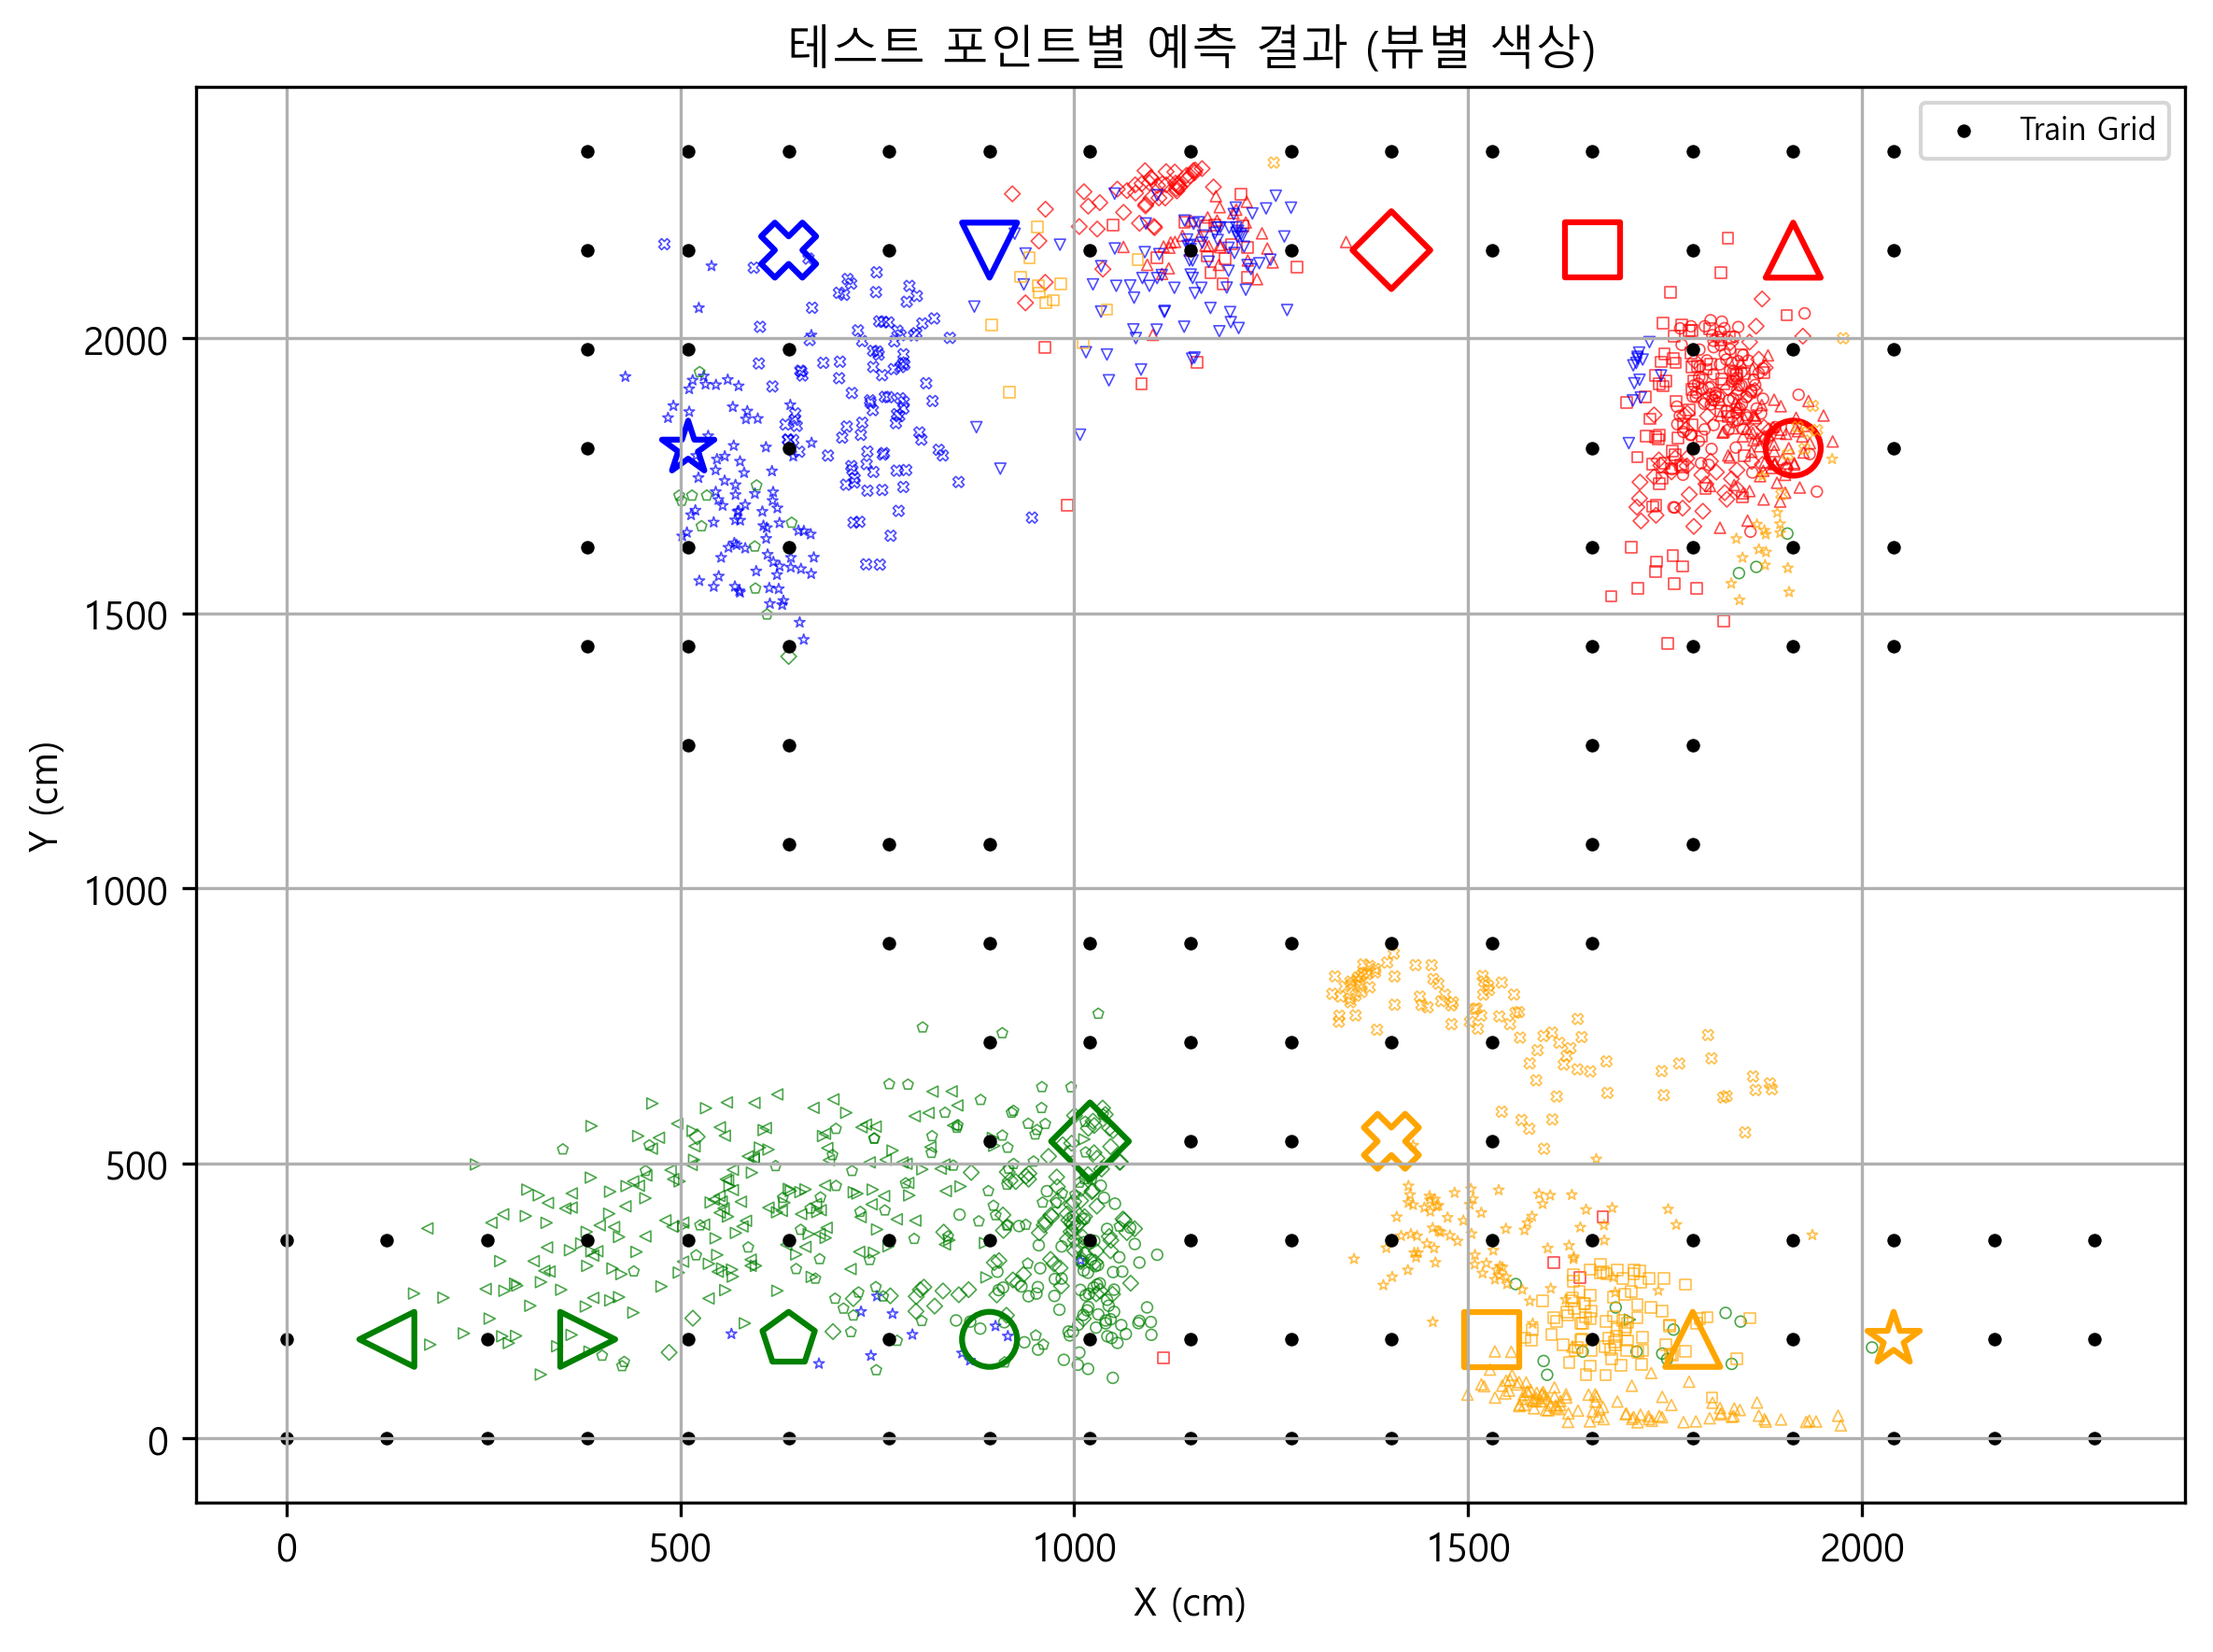

In [67]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

EXPERIMENT = 100

# 1) raw‐experiment 예측값 로드 (point_idx, x_cm, y_cm)
data = np.loadtxt("result_test_raw_experiments0701.txt", skiprows=1)
point_idx = data[:,0].astype(int)    # (14100,)
preds_cm   = data[:,1:]              # (14100,2)

# 2) 그리드 원본 좌표 (raw cm)
y1_all = np.array([
    0,127.5,255.0,382.5,510.0,637.5,765.0,892.5,1020.0,1147.5,1275.0,1402.5,1530.0,1657.5,1785.0,1912.5,2040.0,2167.5,2295.0,
    0,127.5,255.0,382.5,510.0,637.5,765.0,892.5,1020.0,1147.5,1275.0,1402.5,1530.0,1657.5,1785.0,1912.5,2040.0,2167.5,2295.0,
    0,127.5,255.0,382.5,510.0,637.5,765.0,892.5,1020.0,1147.5,1275.0,1402.5,1530.0,1657.5,1785.0,1912.5,2040.0,2167.5,2295.0,
    892.5,1020.0,1147.5,1275.0,1402.5,1530.0,
    892.5,1020.0,1147.5,1275.0,1402.5,1530.0,
    765.0,892.5,1020.0,1147.5,1275.0,1402.5,1530.0,1657.5,
    637.5,765.0,892.5,1657.5,1785.0,
    510.0,637.5,1657.5,1785.0,
    382.5,510.0,637.5,1657.5,1785.0,1912.5,2040.0,
    382.5,510.0,637.5,1657.5,1785.0,1912.5,2040.0,
    382.5,510.0,637.5,1657.5,1785.0,1912.5,2040.0,
    382.5,510.0,637.5,1785.0,1912.5,2040.0,
    382.5,510.0,637.5,765.0,892.5,1020.0,1147.5,1275.0,1402.5,1530.0,1657.5,1785.0,1912.5,2040.0,
    382.5,510.0,637.5,765.0,892.5,1020.0,1147.5,1275.0,1402.5,1530.0,1657.5,1785.0,1912.5,2040.0
])
y2_all = np.array([
    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
    180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,
    360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,
    540,540,540,540,540,540,
    720,720,720,720,720,720,
    900,900,900,900,900,900,900,900,
    1080,1080,1080,1080,1080,
    1260,1260,1260,1260,
    1440,1440,1440,1440,1440,1440,1440,
    1620,1620,1620,1620,1620,1620,1620,
    1800,1800,1800,1800,1800,1800,1800,
    1980,1980,1980,1980,1980,1980,
    2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,
    2340,2340,2340,2340,2340,2340,2340,2340,2340,2340,2340,2340,2340,2340
])

# 3) 테스트 인덱스 정의
test1 = [105,121,123,125]
test2 = [101,115,117]
test3 = [20,22,24,26,58]
test4 = [31,33,35,61]
test_indices = test1 + test2 + test3 + test4

# 4) 실제 포인트 좌표
test_x = y1_all[test_indices]
test_y = y2_all[test_indices]

# 5) 색상·마커 세팅
colors  = ['red','blue','green','orange']  # view1~view4
markers = ['o','D','s','^','*','X','v','<','>','p']

plt.figure(figsize=(8,6), dpi=300)

for i, idx in enumerate(test_indices):
    # 해당 point_idx의 100개 예측만 뽑기
    mask = (point_idx == idx)
    x_pred = preds_cm[mask,0]
    y_pred = preds_cm[mask,1]

    # 뷰별 색상 결정
    if   idx in test1: view_id = 0
    elif idx in test2: view_id = 1
    elif idx in test3: view_id = 2
    else:               view_id = 3

    # 6) 예측 분포
    plt.scatter(
        x_pred, y_pred,
        s=8,
        edgecolors=colors[view_id],
        facecolors='none',
        marker=markers[i % len(markers)],
        linewidths=0.4,
        alpha=0.7
    )
    # 7) 실제 그리드 지점
    plt.scatter(
        test_x[i], test_y[i],
        s=200,
        edgecolors=colors[view_id],
        facecolors='none',
        marker=markers[i % len(markers)],
        linewidths=1.5
    )

# 8) Train grid (나머지 지점) 찍기
all_idx   = np.arange(len(y1_all))
train_idx = [i for i in all_idx if i not in test_indices]
train_x   = y1_all[train_idx]
train_y   = y2_all[train_idx]

plt.scatter(
    train_x, train_y,
    s=10, color='black', marker='o',
    edgecolors='black', linewidths=0.3,
    label='Train Grid'
)

plt.title("테스트 포인트별 예측 결과 (뷰별 색상)")
plt.xlabel("X (cm)"); plt.ylabel("Y (cm)")
plt.grid(True)
plt.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.savefig("prediction_plot_v4_fixed.png", dpi=300)
plt.show()

